# Regression trees

## Learning objectives
- Understand how decision trees can be used for regression
- Adjust our classification tree to perform regression

## Intro - from classification to regression
We already know that a broad dichotomy of problems is that they are often either classification or regression problems. 
We've seen other models like SVMs can be used for either type of problem.
Decision trees can also be used for both.
How?
Classification trees put all of the datapoints into different regions.
Hopefully each region contains examples well within their boundary.
Regression trees make predictions based on a regression line that *is* the boundary.
So hopefully all of the datapoints follow the boundary line closely.

In the case of regression trees, in each region we predict a constant output.
That is, there is a step difference between the values predicted in adjactent regions, and for each region we predict a constant value for any datapoint that lies within.

# show img of classification vs regression by tree

## How do we make splits?
For regression, it doesnt make sense to split the space in the same way as in classification,
where we split the feature space by selecting the split which minimised the total weighted Geni impurity of the resulting regions.
Instead the measure of the goodness of a split should be based on a metric that makes sense for minimising continuous predictions, like mean squared error.

So we will test each possible split point (along feature values and feature axes), like what we did when building our classification tree, but now we will choose the split based on minimising MSE.

Let's get some regression data.


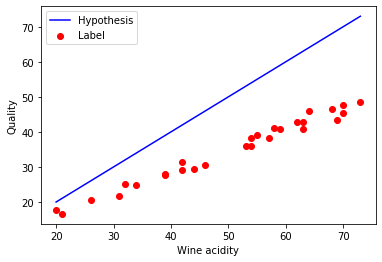

In [4]:
# DON'T WORRY ABOUT THIS CELL, IT JUST SETS SOME STUFF UP
import numpy as np
import matplotlib.pyplot as plt

def get_data():
    data = np.genfromtxt('DATA/winequality-red.csv', delimiter=';') ## Import income data and save to variable.
    data = data[1:] # remove NaNs
    # data=data[:2]
    X = data[:, :-1] # get all of the rows and all but the last column (the last column is the labels)
    X = X[:, 0]
    X = np.expand_dims(X, 1)
    Y = data[:, -1] # get the last column as the labels
    return X, Y

def plot_data(X, Y):
    plt.figure()
    plt.scatter(X, Y, c='r')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

def visualise_predictions(X, H, Y):
    plt.figure()
    plt.scatter(X, Y, c='r', label='Label')
    domain = np.linspace(min(X), max(X))
    plt.plot(domain, H(domain), c='b', label='Hypothesis')
    plt.legend()
    plt.xlabel('Wine acidity')
    plt.ylabel('Quality')
    plt.show()

def test_h(X):
    return X

X, Y = get_data()
visualise_predictions(X, test_h, Y)

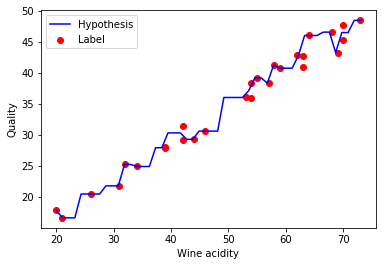

{
    "split_loss": 5.243685188577486,
    "feature_to_split_on": 0,
    "value_to_split_on": 23.5,
    "positive_branch": {
        "split_loss": 7.126619787589046,
        "feature_to_split_on": 0,
        "value_to_split_on": 37.0,
        "positive_branch": {
            "split_loss": 2.8324862590301096,
            "feature_to_split_on": 0,
            "value_to_split_on": 48.5,
            "positive_branch": {
                "split_loss": 2.2977791136895442,
                "feature_to_split_on": 0,
                "value_to_split_on": 54.5,
                "positive_branch": {
                    "split_loss": 2.0302943589951736,
                    "feature_to_split_on": 0,
                    "value_to_split_on": 61.5,
                    "positive_branch": {
                        "split_loss": 1.2463562491886304,
                        "feature_to_split_on": 0,
                        "value_to_split_on": 63.0,
                        "positive_branch": {
                

In [6]:
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint
import json
import copy

class RegressionTree:
    def __init__(self, max_depth=4):
        self.max_depth = max_depth

    def MSE(self, prediction, label):
        """Compute the mean squared error between a vector of predictions and corresponding labels"""
        return np.mean((prediction - label)**2)

    def get_region_loss(self, examples_in_region):
        """Return the MSE loss for a region"""
        x, Y = examples_in_region
        prediction = np.mean(Y)
        return self.MSE(prediction, Y)

    def get_split_loss(self, x, Y, split_pos):
        """Get the weighted loss for a given split"""
        in_first_region = (x[x > split_pos], Y[x > split_pos])
        proportion_in_first_region = len(in_first_region) / len(x)
        not_in_first_region = (x[x <= split_pos], Y[x <= split_pos])
        proportion_not_in_first_region = 1 - proportion_in_first_region
        loss = 0
        loss += proportion_in_first_region * self.get_region_loss(in_first_region)
        loss += proportion_not_in_first_region * self.get_region_loss(not_in_first_region)
        return loss

    def get_split_candidates(self, x):
        """Get the values of a given feature to be tested as a potential place to split"""
        return (x[:-1] + x[1:]) / 2

    def get_best_split(self, X, Y):
        """Return the best feature and the best value to split the provided datapoints on"""
        best_feature_to_split_on = None
        best_loss = float('inf')
        best_split_pos = None
        n_features = 1
        for feature_idx in range(n_features): # for each feature
            x = X[:, feature_idx] # get this feature from each example
            split_pos, split_loss = self.get_best_split_on_this_feature(x, Y)
            # print('feature loss:', split_loss)
            if split_loss < best_loss:
                best_split_pos = split_pos
                best_loss = split_loss
                best_feature_to_split_on = feature_idx
        # print('best_split_loss:', best_loss)
        return best_split_pos, best_loss, best_feature_to_split_on

    def get_best_split_on_this_feature(self, x, Y):
        """Get the best value to split the data on along this axis"""
        split_candidates = self.get_split_candidates(x)
        best_loss = float('inf')
        best_split_pos = None
        for split_pos in split_candidates:
            loss = self.get_split_loss(x, Y, split_pos)
            if loss < best_loss:
                best_loss = loss
                best_split_pos = split_pos
        return best_split_pos, best_loss

    def extend_tree(self, X, Y, depth=0):
        """Recursively make branches of the tree"""
        split_val, split_loss, split_feature = self.get_best_split(X, Y)
        # tree['split']
        if split_val == None: # split val will not exist (None) if there is only one datapoint in the split
            # dsfnucis
            new_branch = {
                'split_loss': 0, # so the split is pure
                'prediction': np.mean(Y)
            }
            return new_branch
        
        positive_idxs = X[:, split_feature] > split_val
        positive_X = X[positive_idxs]
        positive_Y = Y[positive_idxs]
        negative_idxs = np.logical_not(positive_idxs)
        negative_X = X[negative_idxs]
        negative_Y = Y[negative_idxs]
        new_branch = {
            'split_loss': split_loss,
        }

        if depth < self.max_depth: # if not yet at max depth
            new_branch.update({
                'feature_to_split_on': split_feature,
                'value_to_split_on': split_val,
                'positive_branch': self.extend_tree(positive_X, positive_Y, depth=depth+1),
                'negative_branch': self.extend_tree(negative_X, negative_Y, depth=depth+1)
            })
        else:
            # print(len(Y))
            new_branch.update({'prediction': np.mean(Y)})
        return new_branch

    def fit(self, X, Y):
        """Fit the tree to the data"""
        self.tree = self.extend_tree(X, Y)

    def predict(self, X):
        """Return a prediction for a given input"""
        classifications = np.zeros(len(X))
        for idx, x in enumerate(X):
            tree = self.tree
            classified = False
            while classified == False:
                if 'prediction' in tree.keys(): # if the example can be classified from this branch (we have reached a leaf)
                    classified = True
                    classifications[idx] = tree['prediction']
                else: # if we need to ask further questions about the example to make splits
                    if x[tree['feature_to_split_on']] > tree['value_to_split_on']: # is the example1 in the positive branch
                        tree = tree['positive_branch'] # 
                    else: 
                        tree = tree['negative_branch']
        return classifications

    def __repr__(self):
        """Return the pretty printed string"""
        return json.dumps(self.tree, indent=4)

regressionTree = RegressionTree(max_depth=30)
regressionTree.fit(X, Y)
visualise_predictions(X, regressionTree.predict, Y)
print(regressionTree)
